In [52]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data_dir = r"C:\Estudio\bioingenieria\proyecto final\PlantVillage"

# División aleatoria (80% train, 20% val)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 2152 images belonging to 3 classes.
Found 430 images belonging to 3 classes.


In [54]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Pesos de clase:", class_weights)


Pesos de clase: {0: np.float64(0.7173333333333334), 1: np.float64(0.7173333333333334), 2: np.float64(4.719298245614035)}


In [55]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # congelamos capas base al principio

# Bloque superior
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(train_gen.num_classes, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)

optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,851 (9.24 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [56]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model_head.keras', save_best_only=True)
]

history_head = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5344 - loss: 1.0229 - val_accuracy: 0.8791 - val_loss: 0.4291 - learning_rate: 1.0000e-04
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7235 - loss: 0.5550 - val_accuracy: 0.9279 - val_loss: 0.2653 - learning_rate: 1.0000e-04
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7783 - loss: 0.4438 - val_accuracy: 0.9419 - val_loss: 0.1912 - learning_rate: 1.0000e-04
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8230 - loss: 0.3667 - val_accuracy: 0.9628 - val_loss: 0.1548 - learning_rate: 1.0000e-04
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 66s 965ms/step - accuracy: 0.8457 - loss: 0.3286 - val_accuracy: 0.9628 - val_loss: 0.1295 - learning_rate: 1.0000e-04
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 65s 954ms/step - accuracy: 0.8685 - loss: 0.2907 - val_accuracy: 0.9581 - val_loss: 0.1248 - learning_rate: 1.0000e-04
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 763ms/step - accuracy: 0.876

In [57]:
# Descongela las últimas 50 capas de MobileNetV2
fine_tune_at = len(base_model.layers) - 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Optimizador más suave para fine-tuning
optimizer_fine = optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer_fine,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks ajustados (recomendación 4 aplicada)
callbacks_ft = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7),
    ModelCheckpoint('best_model_finetune.keras', save_best_only=True)
]

# Pesos de clase (para balancear la clase "healthy")
class_weights = {
    0: 1.0,   # Early blight
    1: 1.0,   # Late blight
    2: 2.5    # Healthy (más peso)
}

# Entrenamiento con más épocas (EarlyStopping detiene cuando sea necesario)
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks_ft
)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 464ms/step - accuracy: 0.8685 - loss: 0.3695 - val_accuracy: 0.9651 - val_loss: 0.1064 - learning_rate: 1.0000e-05
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 561ms/step - accuracy: 0.9145 - loss: 0.2617 - val_accuracy: 0.9558 - val_loss: 0.1145 - learning_rate: 1.0000e-05
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 64s 949ms/step - accuracy: 0.9266 - loss: 0.2352 - val_accuracy: 0.9442 - val_loss: 0.1405 - learning_rate: 1.0000e-05
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9280 - loss: 0.2292 - val_accuracy: 0.9442 - val_loss: 0.1441 - learning_rate: 5.0000e-06
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9368 - loss: 0.1850 - val_accuracy: 0.9465 - val_loss: 0.1243 - learning_rate: 5.0000e-06
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 67s 978ms/step - accuracy: 0.9363 - loss: 0.1930 - val_accuracy: 0.9465 - val_loss: 0.1277 - learning_rate: 2.5000e-06


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step

Reporte de clasificación:
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      0.98      0.99       200
 Potato___Late_blight       0.98      0.94      0.96       200
     Potato___healthy       0.73      1.00      0.85        30

             accuracy                           0.97       430
            macro avg       0.90      0.97      0.93       430
         weighted avg       0.97      0.97      0.97       430



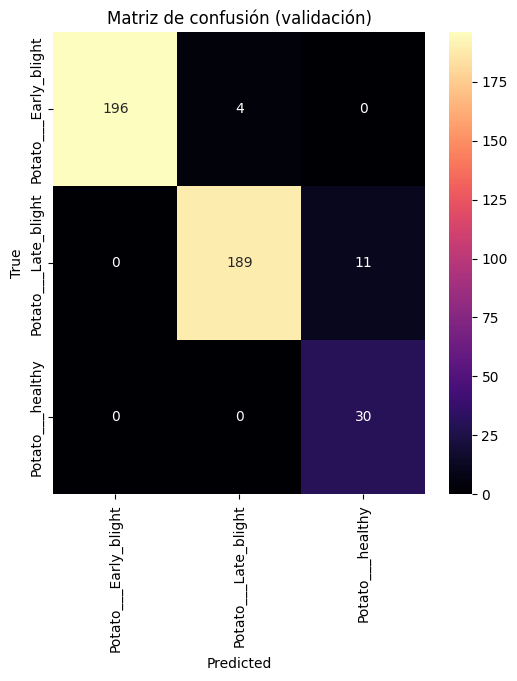

In [58]:
# Evaluar modelo
val_preds = model.predict(val_gen)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Matriz de confusión (validación)')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


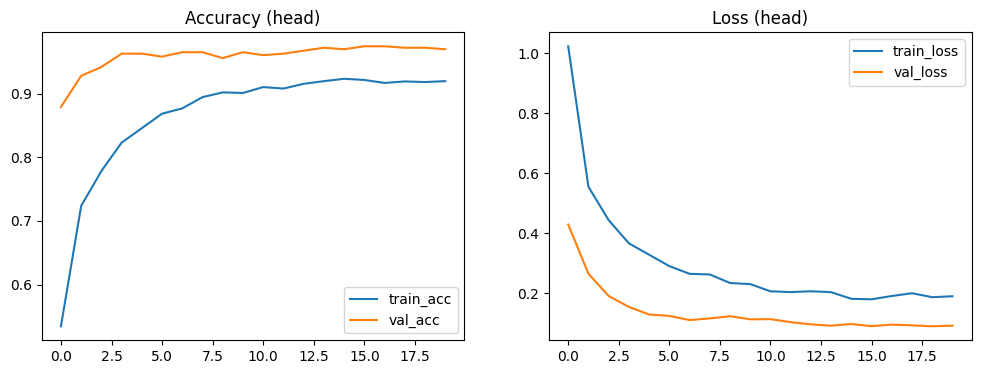

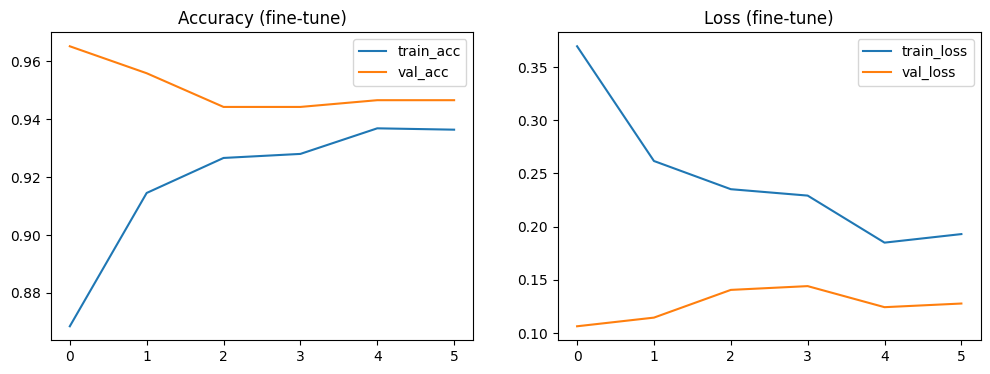

In [59]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='train_acc')
    plt.plot(epochs, val_acc, label='val_acc')
    plt.title(f'Accuracy ({title})')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title(f'Loss ({title})')
    plt.legend()
    plt.show()

plot_history(history_head, "head")
plot_history(history_ft, "fine-tune")
